### Cab-Driver Agent

In [73]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [74]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [75]:
states_track = collections.defaultdict(dict)


In [76]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((4,3,2),(4,1)),((3,4,2),(2,3)),((2,2,2),(3,2)),((1,22,4),(1,3)), ((4,24,3),(3,4))]     
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []

In [77]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [78]:
class DQNAgent:
    def __init__(self, state_size, action_size, discount_factor=0.90, learning_rate=0.001,
                 epsilon=1, epsilon_decay=0.0003, epsilon_min=0.00001):
        # Define size of state and action and all hyperparameters
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon_max = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 32
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions_index):
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

    def append_sample(self, state, action, reward, next_state):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))

    # pick samples randomly from replay memory (with batch_size) and train the network
    @tf.function # To train fast
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))  # write here
            actions, rewards = [], []

            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state

                # Predict the target from earlier model
                target = self.model.predict(update_input)
                # Get the target for the Q-network
                target_qval = self.model.predict(update_output)
                # Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
            
    def save(self, name):
        self.model.save(name)

In [79]:
Episodes = 5000

### DQN block

In [80]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []
env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(env.state_init)))

for episode in range(Episodes):
    # Call the environment
    env = CabDriver()
    score = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()
    terminal_state = False
    t = 0
    count = 1
    while not terminal_state:
        #print("count = {}".format(count))
        count += 1
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        # 2. Evaluate your reward and next state
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state), action_index, reward, env.state_encod_arch1(next_state))
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        if t >= 24 * 30:
            print("state terminated")
            terminal_state = True

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode, score, len(agent.memory), agent.epsilon))
    # every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
    if episode % 1000 == 0:
        agent.save(name="model.h5")
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)

Streaming output truncated to the last 5000 lines.
state terminated
episode 2502, reward 205.0, memory_length 2000, epsilon 0.47208849698616884
state terminated
episode 2503, reward 94.0, memory_length 2000, epsilon 0.47194689467848117
state terminated
episode 2504, reward -50.0, memory_length 2000, epsilon 0.4718053348451143
state terminated
episode 2505, reward 105.0, memory_length 2000, epsilon 0.4716638174733279
state terminated
episode 2506, reward 45.0, memory_length 2000, epsilon 0.4715223425503854
state terminated
episode 2507, reward 156.0, memory_length 2000, epsilon 0.4713809100635541
state terminated
episode 2508, reward 330.0, memory_length 2000, epsilon 0.47123952000010494
state terminated
episode 2509, reward -40.0, memory_length 2000, epsilon 0.47109817234731294
state terminated
episode 2510, reward -7.0, memory_length 2000, epsilon 0.47095686709245677
state terminated
episode 2511, reward 36.0, memory_length 2000, epsilon 0.47081560422281893
state terminated
episode 25

Rewards are started increasing after 4000 episodes and if we try to run for more episodes then we can see more rewards. 


## Tracking Convergence

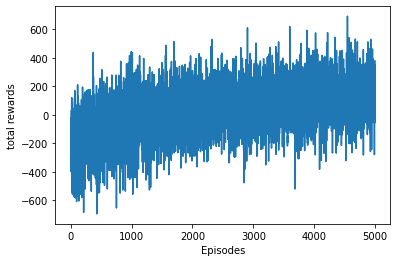

In [87]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("Episodes")
plt.ylabel("total rewards")
plt.show()

In [82]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 100:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-223.09, -198.95, -183.52, -175.6, -179.7, -124.96, -94.16, -92.1, -90.09, -54.44, -84.84, -20.45, -48.69, -45.92, -15.68, -13.2, -1.8, 7.96, -2.15, 30.16, 30.46, 32.69, 38.54, 60.04, 70.5, 82.05, 10.76, 67.3, 32.99, 70.91, 61.61, 87.8, 90.3, 72.84, 105.79, 99.53, 111.1, 104.24, 100.48, 126.02, 136.87, 110.86, 149.45, 130.37, 127.99, 119.01, 149.72, 146.64, 134.23, 148.52]


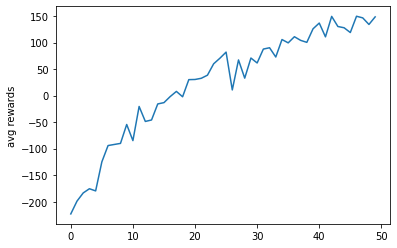

In [83]:
## Check Convergence by tracking average rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("avg rewards")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [85]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

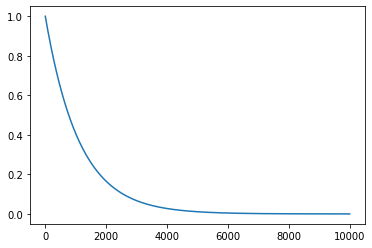

In [86]:
plt.plot(time, epsilon)
plt.show()